# Constrained $k$-means clustering

In [1]:
import numpy as np
import cvxpy as cp
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns

sns.set_theme(style='ticks', font_scale=1.5)
mpl.rcParams["text.usetex"] = True
mpl.rcParams["mathtext.fontset"] = 'cm'
mpl.rcParams['font.family'] = ['sans-serif']

np.random.seed(10015)

In [2]:
# generate data
m_group = 100
sigma = 0.05
rad = 2
t = np.linspace(0, rad, m_group)
samples = [
    np.column_stack((rad - t, t)),
    np.column_stack((-t, rad - t)),
    np.column_stack((-rad + t, -t)),
    np.column_stack((t, -rad + t))
]
for gs in samples:
    gs += np.random.normal(scale=sigma, size=(m_group, 2))

# generate constraints
A = np.array([
    [0.8, 0.6],
    [-0.7, 0.9],
    [-1, -0.5],
    [1, -1],
    [0.3, 0.9]
])
b = np.array([[1, 0.8, 0.6, 0.7, 0.8]]).T

In [3]:
### problem data
xs = np.vstack(samples)  # ndarray: dataset features
ys = None  # ndarray: dataset observations
m = xs.shape[0]  # int: number of samples in the dataset
n = xs.shape[1]

### hyperparameters
eps = 1e-6  # float: termination criterion

### P-problem
K = 4
thetas = []  # list of cp.Variable objects: model parameters
r = []  # list of cp.Expression objects: loss functions
for k in range(K):
    thetas.append(cp.Variable((1, n)))
    r.append(cp.sum(cp.square(xs - thetas[-1]), axis=1))

ztil = cp.Parameter((m, K), nonneg=True)
Pobj = cp.sum(cp.multiply(ztil, cp.vstack(r).T))
Preg = 0  # cp.Expression: regularization on model parameters
Pconstr = [A @ theta.T <= b for theta in thetas]  # list of cp.Constraint objects: model parameter constraints
Pprob = cp.Problem(cp.Minimize(Pobj + Preg), Pconstr)
assert Pprob.is_dcp()

### F-problem
rtil = cp.Parameter((K, m))
z = cp.Variable((m, K))
Fobj = cp.sum(cp.multiply(z, rtil.T))
Freg = 0  # cp.Expression: regularization on latent factors
Fconstr = [z >= 0, z <= 1, cp.sum(z, axis=1) == 1]
Fprob = cp.Problem(cp.Minimize(Fobj + Freg), Fconstr)
assert Fprob.is_dcp()

### solve, terminate when the F- and P-objective converge
i = 0
while True:
    i += 1
    if ztil.value is None:
        ztil.value = np.random.dirichlet(np.ones(K), size=m)
    else:
        ztil.value = np.abs(z.value)
    Pprob.solve()

    rtil.value = cp.vstack(r).value
    Fprob.solve()

    print(f"Iteration {i}: P-problem value: {Pobj.value}, F-problem value: {Fobj.value}, gap: {np.abs(Pobj.value - Fobj.value)}.")
    if np.abs(Pobj.value - Fobj.value) < eps:
        break

Iteration 1: P-problem value: 1071.6938710180875, F-problem value: 1007.3433644263896, gap: 64.35050659169792.
Iteration 2: P-problem value: 557.9732959772086, F-problem value: 522.2936121489529, gap: 35.67968382825575.
Iteration 3: P-problem value: 499.13676624033013, F-problem value: 449.82754217343927, gap: 49.30922406689086.
Iteration 4: P-problem value: 382.4094217198699, F-problem value: 350.9492453087827, gap: 31.460176411087218.
Iteration 5: P-problem value: 337.3370639293573, F-problem value: 335.4162689634518, gap: 1.920794965905543.
Iteration 6: P-problem value: 335.4162694357827, F-problem value: 335.41626896345167, gap: 4.7233100985977217e-07.


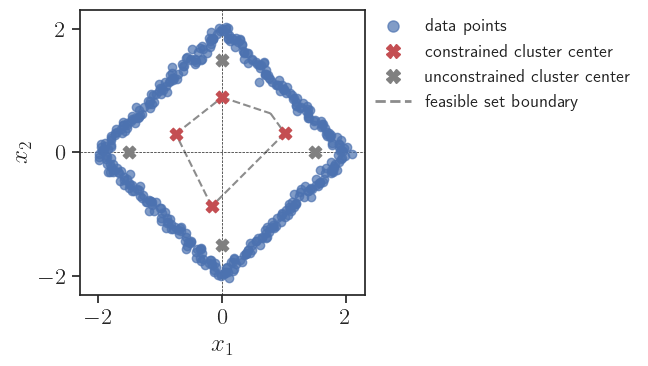

In [4]:
fig, axs = plt.subplots(1, 1, figsize=(8.5, 4))

# plot data
for gs in samples:
    axs.scatter(gs[:, 0], gs[:, 1], alpha=0.7, color='C0')

# plot feasible set
axs.plot((0, 0.78), (0.89, 0.63), color='k', linewidth=1.5, linestyle='dashed', alpha=0.5)
axs.plot((0.78, 1.01), (0.63, 0.31), color='k', linewidth=1.5, linestyle='dashed', alpha=0.5)
axs.plot((1.01, -0.17), (0.31, -0.87), color='k', linewidth=1.5, linestyle='dashed', alpha=0.5)
axs.plot((-0.17, -0.75), (-0.87, 0.3), color='k', linewidth=1.5, linestyle='dashed', alpha=0.5)
axs.plot((-0.75, 0), (0.3, 0.89), color='k', linewidth=1.5, linestyle='dashed', alpha=0.5)

# plot unconstrained cluster centers
axs.scatter([-1.5, 0, 1.5, 0], [0, 1.5, 0, -1.5], color='gray', marker='X', s=80, zorder=10)

# plot constrained cluster centers
for theta in thetas:
    x, y = theta.value[0]
    axs.scatter(x, y, color='r', marker='X', s=80, zorder=10)

axs.axhline(0, color='k', linestyle='--', linewidth=0.5, zorder=-1)
axs.axvline(0, color='k', linestyle='--', linewidth=0.5, zorder=-1)
axs.set_xlim(-2.3, 2.3)
axs.set_ylim(-2.3, 2.3)
axs.set_xticks([-2, 0, 2])
axs.set_yticks([-2, 0, 2])
axs.set_xlabel('$x_1$')
axs.set_ylabel('$x_2$')
axs.set_aspect('equal')
handles = [
    mlines.Line2D([], [], color='C0', linestyle='none', marker='o', markersize=8, alpha=0.7, label='data points'),
    mlines.Line2D([], [], color='r', linestyle='none', marker='X', markersize=10, label='constrained cluster center'),
    mlines.Line2D([], [], color='gray', linestyle='none', marker='X', markersize=10, label='unconstrained cluster center'),
    mlines.Line2D([], [], color='k', linewidth=2, linestyle='dashed', alpha=0.5, label='feasible set boundary'),
]
fig.legend(handles=handles, frameon=False, fontsize=13, bbox_to_anchor=(1, 0.95))
plt.tight_layout()

fig.savefig('../figures/constr_kmeans.pdf', bbox_inches='tight')